# IMPORT

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit, prange
from os import listdir
from os.path import isfile, join

plt.style.use(['science', 'grid'])

DPI = 500

## Ground Truth

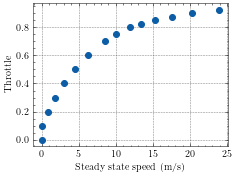

In [2]:
df = pd.read_csv('../steady_state_response.csv')
gt_v = np.array(df.ssv)
gt_u = np.array(df.u)

plt.figure()
plt.scatter(gt_v, gt_u)
plt.xlabel('Steady state speed (m/s)')
plt.ylabel('Throttle')
plt.savefig('img/ground_truth.png', dpi=DPI, transparent=True, bbox_inches='tight')
plt.show()

## Simulation Results

In [3]:
dir_names =  ['pso', 'apso', 'fpa_original', 'fpa']
param_names = ['beta1', 'beta2', 'beta3']

data_loss = {}
data_loss_summary = {'name': [], 'min': [], 'max': [], 'mean': [], 'std': []}
data_best_loss_history = {}
data_best_param = {'name': []}
for param_name in param_names:
    data_best_param[param_name] = []

temp = np.Inf
    
for dir_name in dir_names:
    lh = np.load('../'+dir_name+'/result/loss_history.npy')
    ph = np.load('../'+dir_name+'/result/param_history.npy')
    lb = np.load('../'+dir_name+'/result/the_best_loss_history.npy')
    pb = np.load('../'+dir_name+'/result/the_best_param_history.npy')
    
    data_loss[dir_name] = lh
    
    data_best_loss_history[dir_name] = lb
    
    data_loss_summary['name'].append(dir_name)
    data_loss_summary['min'].append(lb[-1])
    data_loss_summary['max'].append(lh.max())
    data_loss_summary['mean'].append(np.mean(lh))
    data_loss_summary['std'].append(np.std(lh))
    
    data_best_param['name'].append(dir_name)
    for i in range(len(param_names)):
        data_best_param[param_names[i]].append(pb[-1][i])
        
    if lb[-1] < temp:
        alg_name = dir_name
        params = np.copy(pb[-1])
        temp = lb[-1]

df_loss = pd.DataFrame(data_loss)
df_loss_summary = pd.DataFrame(data_loss_summary)
df_best_param = pd.DataFrame(data_best_param)
df_best_loss_history = pd.DataFrame(data_best_loss_history)

print('The minimum loss algorithm: '+ alg_name)
print(params)

The minimum loss algorithm: pso
[ 0.85009553 -0.14497243  0.09623465]


In [4]:
df_loss_summary

,name,min,max,mean,std
0,pso,0.000012,0.000012,0.000012,3.484426e-20
1,apso,0.000012,0.038092,0.007186,9.447570e-03
2,fpa_original,0.000012,0.000012,0.000012,2.427189e-20
3,fpa,0.000012,0.000012,0.000012,2.594964e-20


# Visualization

In [5]:
@njit
def forward_propagation(u, param):
    b1, b2, b3 = param
    
    out = b1 * (1 - np.exp(b2*(u))) + b3
    out = np.fmax(out, 0.)
    
    # When the vehicle is not moving
    out[u <= 1e-2] = 0.
    
    return out

_ = forward_propagation(np.array([0.0, 0.1]), np.ones(3)*0.5)

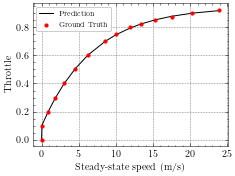

In [6]:
plt.figure()
plt.plot(gt_v, forward_propagation(gt_v, params), color='black', label='Prediction', zorder=1)
plt.scatter(gt_v, gt_u, s=10., color='red', label='Ground Truth', zorder=2)
plt.xlabel('Steady-state speed (m/s)')
plt.ylabel('Throttle')
plt.legend(fontsize=7)
plt.savefig('img/result.png', dpi=DPI, transparent=True, bbox_inches='tight')
plt.show()

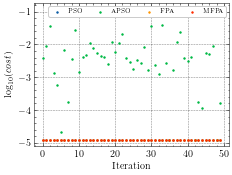

In [7]:
plt.figure()
names = ['PSO', 'APSO', 'FPA', 'MFPA']
for i in range(len(dir_names)):
    plt.scatter(df_loss.index.values, np.log10(df_loss[dir_names[i]]), s=2., label=names[i])
plt.xlabel('Iteration')
plt.ylabel('$\mathrm{log}_{10}(cost)$')
plt.legend(fontsize=6,  ncol=4, loc='upper right')
plt.ylim([None,-0.75])
plt.savefig('img/stability_check.png', dpi=DPI, transparent=True, bbox_inches='tight')
plt.show()